In [ ]:
import socket
import pandas as pd
from datetime import datetime as dt
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext as sc
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.catalog import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

# Setup

In [ ]:
# Pandas settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [ ]:
LOCAL_IP = socket.gethostbyname(socket.gethostname())
spark = (
    SparkSession
    .builder
    .master('k8s://https://10.32.7.103:6443')
    .config('spark.driver.host', LOCAL_IP)
    .config('spark.driver.bindAddress', '0.0.0.0')
    .config('spark.executor.instances', '2')
    .config('spark.executor.cores', '2')
    .config('spark.cores.max', '4')
    .config('spark.executor.memory', '4g')
    #.config('spark.sql.execution.arrow.enabled', 'true')
    .config('spark.kubernetes.namespace', 'schumakov-338590')
    .config('spark.kubernetes.container.image', 'node03.st:5000/spark-executor:schumakov-338590')
    .config('spark.kubernetes.container.image.pullPolicy', 'Always')
    .config('spark.kubernetes.executor.deleteOnTermination', 'false')
    .getOrCreate()
)

In [ ]:
# For checking
!hdfs dfs -ls /tmp/agalin-335417/ibd_data/posts

Found 13 items
-rw-r--r--   3 agalin-335417 supergroup   91289802 2022-06-26 14:01 /tmp/agalin-335417/ibd_data/posts/posts_1tv.parquet
-rw-r--r--   3 agalin-335417 supergroup  101119380 2022-06-26 14:04 /tmp/agalin-335417/ibd_data/posts/posts_lentach.parquet
-rw-r--r--   3 agalin-335417 supergroup  216703435 2022-06-27 00:54 /tmp/agalin-335417/ibd_data/posts/posts_life.parquet
-rw-r--r--   3 agalin-335417 supergroup   27474132 2022-06-26 22:16 /tmp/agalin-335417/ibd_data/posts/posts_mash.parquet
-rw-r--r--   3 agalin-335417 supergroup  104658861 2022-06-26 18:42 /tmp/agalin-335417/ibd_data/posts/posts_meduza.parquet
-rw-r--r--   3 agalin-335417 supergroup   85278321 2022-06-26 20:33 /tmp/agalin-335417/ibd_data/posts/posts_plohienov.parquet
-rw-r--r--   3 agalin-335417 supergroup  123844043 2022-06-26 20:36 /tmp/agalin-335417/ibd_data/posts/posts_rentv.parquet
-rw-r--r--   3 agalin-335417 supergroup  216554917 2022-06-26 20:42 /tmp/agalin-335417/ibd_data/posts/posts_ria.parquet
-rw-r--r

In [ ]:
# This function is useful for saving stages results if it is needed to use them in the further work
def save_parquet(data, name):
    file_name = '/tmp/schumakov-338590/Course_project_results/' + name
    start_time = dt.now()
    data.write.parquet(file_name, mode = 'overwrite')
    print('>>>>>> file: ' + file_name + ' >>> time: ' + str(dt.now() - start_time))
    data = spark.read.parquet(file_name)

## Getting data

In [ ]:
def get_data():
    posts = spark.createDataFrame([], spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/posts/rbk_posts_parquet.parquet").drop('attachments','copy_history','comments','copyright').schema)
    comments = spark.createDataFrame([], spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/comments/users_friends_sent_rbk.parquet").schema)
    users = spark.createDataFrame([], spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/users/rbk_users_friends_parquet.parquet").schema)

    path_posts = !hdfs dfs -ls /tmp/agalin-335417/ibd_data/posts
    for i in path_posts[6:]:
        posts = posts.union(spark.read.parquet('hdfs:///' + i.split(' ')[-1]).drop('attachments','copy_history','comments','copyright'))
    path_comments = !hdfs dfs -ls /tmp/agalin-335417/ibd_data/comments
    for i in path_comments[6:]:
        comments = comments.union(spark.read.parquet('hdfs:///' + i.split(' ')[-1]))
    path_users = !hdfs dfs -ls /tmp/agalin-335417/ibd_data/users
    for i in path_users[6:]:
        users = users.union(spark.read.parquet('hdfs:///' + i.split(' ')[-1]))
   
    return posts, comments, users

In [ ]:
posts, comments, users = get_data()

In [ ]:
# Remove deplicates from users by profile ids
users = users.dropDuplicates(['id'])

In [ ]:
names = spark.read.parquet("hdfs:///tmp/agalin-335417/ibd_data/CIS_names_parquet.parquet")

In [ ]:
posts.limit(3).toPandas()

,id,owner_id,from_id,created_by,date,text,reply_post_id,reply_owner_id,likes,reposts,post_type
0,2862067,-25380626,-25380626,NaN,1646227305,Первый канал — в прямом эфире ⬇,NaN,NaN,"(1, 1, 3672, 0)","(835, 0)",post
1,2943800,-25380626,-25380626,NaN,1656169380,К 110-летию со дня рождения Сергея Филиппова ❤...,NaN,NaN,"(1, 1, 105, 0)","(5, 0)",post
2,2943765,-25380626,-25380626,NaN,1656162180,"Лига Бокса\nСуббота, 25 июня\nИнтерконтинентал...",NaN,NaN,"(1, 1, 21, 0)","(3, 0)",post


In [ ]:
comments.limit(3).toPandas()

,date,from_id,id,owner_id,post_id,text,prediction
0,1646228423,134948776,2862090,-25380626,2862067,Эти придурки уже взламывают аптечные приложени...,neutral
1,1646228427,162828015,2862091,-25380626,2862067,Это надо всё ОСТАНОВИТЬ мирным путём !!!,negative
2,1646229306,4463147,2862103,-25380626,2862067,"Фейсбук заблокировал меня сразу же, как только...",neutral


In [ ]:
users.limit(3).toPandas()

,id,private,friends,subscriptions,first_name,last_name,blacklisted,country,education,followers_count,has_photo,home_town,interests,has_mobile,occupation,religion,inspired_by,langs,political,verified,career,deactivated,is_closed
0,25084,0,"[14075, 14634, 14845, 21860, 23678, 57929, 751...","[22741624, 29369324, 88084325, 30525261, 41807...",Eduard,Boytsov,0.0,"(1, Russia)",NaN,1114.0,1,𝓢𝓐𝓘𝓝𝓣-𝓟𝓔𝓣𝓔𝓡𝓢𝓑𝓤𝓡𝓖,,1.0,"(None, None, None, 45301852, LEX - Ваша особая...",NaN,NaN,NaN,NaN,0.0,"[(2, None, 1, None, 36589976, IT, None), (None...",None,False
1,35323,0,None,None,Anatoly,Umerenkov,0.0,"(1, Russia)",NaN,NaN,1,None,None,1.0,"(None, None, None, None, Психиатрическая больн...",NaN,NaN,NaN,NaN,0.0,None,None,True
2,50287,0,None,None,Kristina,Alexandrova,0.0,"(1, Russia)",NaN,NaN,1,None,None,1.0,"(None, None, None, 58727144, ЦБ РФ Центральный...",NaN,NaN,NaN,NaN,0.0,None,None,True


In [ ]:
users.count()

1528523

In [ ]:
comments.count()

25970735

In [ ]:
posts.count()

1271062

# Data processing

In [ ]:
getLen = spark.udf.register('getLen', lambda x: len(x))
getLen

<function __main__.<lambda>(x)>

## User account types

In [ ]:
users_opened = users.filter(col('is_closed') == False)
users_closed = users.filter(col('is_closed') == True)

In [ ]:
users_banned = users.filter(col('deactivated') == 'banned')
users_deleted = users.filter(col('deactivated') == 'deleted')
users_verified = users.filter(col('verified') == 1)
users_unverified = users.filter(col('verified') == 0)

In [ ]:
n_unique = users.count()
n_opened = users_opened.count()
n_closed = users_closed.count()
n_banned = users_banned.count()
n_deleted = users_deleted.count()
n_verified = users_verified.count()
n_unverified = users_unverified.count()

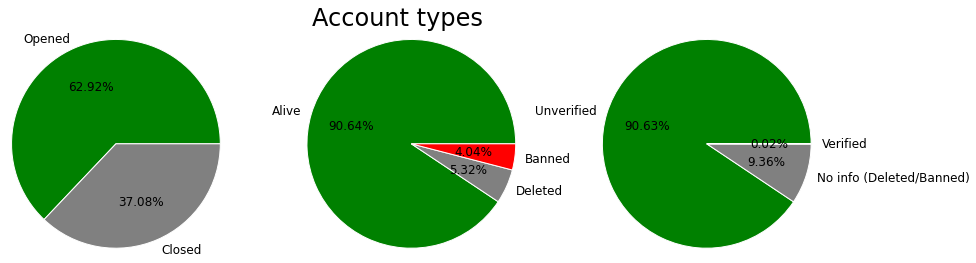

In [ ]:
fig, ax = plt.subplots(figsize=(15,4), nrows=1, ncols=3)
fig.suptitle("Account types", fontsize=24)
ax[0].pie([n_opened, n_closed], 
          labels=['Opened', 'Closed'], 
          autopct='%1.2f%%', 
          radius=1.2, 
          wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, 
          textprops={'size': 12}, 
          colors=['green', 'grey'])
ax[1].pie([n_unique - n_banned - n_deleted, n_deleted, n_banned], 
          labels=['Alive', 'Deleted', 'Banned'], 
          autopct='%1.2f%%', 
          radius=1.2, 
          wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, 
          textprops={'size': 12}, 
          colors=['green', 'grey', 'red'])
ax[2].pie([n_unverified, n_unique - n_verified - n_unverified, n_verified], 
          labels=['Unverified', 'No info (Deleted/Banned)', 'Verified'], 
          autopct='%1.2f%%', 
          radius=1.2, 
          wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'}, 
          textprops={'size': 12}, 
          colors=['green','grey'])
plt.show()

## User account data

In [ ]:
users_opened_proc = users_opened.withColumn('followers_count', col('followers_count').cast(IntegerType()))\
                                .withColumn('interests', when(col('interests') == '', None).otherwise(col('interests')))\
                                .withColumn('home_town', when(col('home_town') == '', None).otherwise(col('home_town')))\
                                .withColumn('deactivated', when(col('deactivated').isNull(), 'Alive').otherwise(col('deactivated')))\
                                .drop('blacklisted')

## User comment data

In [ ]:
users_neg_com_share = comments.groupBy('from_id')\
                              .agg(count(lit(0)).name('n_total'), count(when(col('prediction') == 'negative', True)).name('n_negative'))\
                              .withColumn('neg_share', col('n_negative') / col('n_total'))\
                              .select(col('from_id').name('id'), 'neg_share')

In [ ]:
# For reading if needed data was already obtained
users_neg_com_share = spark.read.parquet('/tmp/schumakov-338590/Course_project_results/users_neg_com_share')

In [ ]:
save_parquet(users_neg_com_share, 'users_neg_com_share')

In [ ]:
users_neg_com_share.head(5)

[Row(id=666692100, neg_share=0.06896551724137931),
 Row(id=183797440, neg_share=0.0),
 Row(id=176869713, neg_share=0.0967741935483871),
 Row(id=226720649, neg_share=0.16049382716049382),
 Row(id=174653663, neg_share=0.0)]

## Critical points

In [ ]:
users_opened_rp = users_opened_proc.filter(col('friends').isNotNull() & col('subscriptions').isNotNull())\
                                   .filter(~col('deactivated').isin('deleted', 'banned'))\
                                   .filter(col('verified') != 1)\
                                   .withColumn('n_friends', getLen(col('friends')))\
                                   .withColumn('n_subscriptions', getLen(col('subscriptions')))\
                                   .withColumn('few_followers', when(col('followers_count') < 10, 1).otherwise(0))\
                                   .withColumn('few_friends', when(col('n_friends') < 10, 1).otherwise(0))\
                                   .withColumn('few_subscriptions', when(col('n_subscriptions') < 10, 1).otherwise(0))\
                                   .withColumn('no_photo', when(col('has_photo') == 0, 1).otherwise(0))\
                                   .withColumn('no_mobile', when(col('has_mobile') == 1, 0).otherwise(1))\
                                   .withColumn('no_town', when(col('home_town').isNull(), 1).otherwise(0))\
                                   .withColumn('no_extended_info', when(col('interests').isNull() 
                                                                        & col('religion').isNull() 
                                                                        & col('country').isNull() 
                                                                        & col('inspired_by').isNull()  
                                                                        & col('political').isNull(), 1).otherwise(0))\
                                   .withColumn('no_prof_info', when(col('education').isNull() 
                                                                    & col('career').isNull() 
                                                                    & col('occupation').isNull(), 1).otherwise(0))\
                                   .withColumn('n_risks', col('few_followers') + col('few_friends') + col('few_subscriptions') + col('no_photo') + col('no_mobile') + col('no_town') + col('no_extended_info') + col('no_prof_info'))

In [ ]:
# For reading if needed data was already obtained
users_opened_rp = spark.read.parquet('/tmp/schumakov-338590/Course_project_results/users_opened_rp')

AnalysisException: Unable to infer schema for Parquet. It must be specified manually.

In [ ]:
save_parquet(users_opened_rp, 'users_opened_rp')

KeyboardInterrupt: 

In [ ]:
users_opened_risks = users_opened_rp.join(users_neg_com_share, on='id', how='inner')

In [ ]:
users_opened_risks.count()

In [ ]:
percentile_90 = users_opened_risks.groupBy()\
                                  .agg(expr('percentile(n_risks, array(0.90))')[0].alias('%90'))\
                                  .toPandas()['%90']\
                                  .values[0]

KeyboardInterrupt: 

In [ ]:
print(percentile_90)

In [ ]:
# Bots and trolls accounts
bots_trolls = users_opened_risks.filter((col('n_risks') > percentile_90) & (col('neg_share') > 0.5))\
                             .select('id')\
                             .union(users_banned.select('id'))\
                             .distinct()

In [ ]:
# For reading if needed data was already obtained
bots_trolls = spark.read.parquet('/tmp/schumakov-338590/Course_project_results/bots_trolls_ids')

KeyboardInterrupt: 

In [ ]:
save_parquet(bots_trolls, 'bots_trolls_ids')

Py4JJavaError: An error occurred while calling o751.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:231)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:874)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 9 in stage 55.0 failed 4 times, most recent failure: Lost task 9.3 in stage 55.0 (TID 300) (10.128.117.242 executor 3): org.apache.spark.SparkException: EOFException occurred while reading the port number from pyspark.daemon's stdout
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:217)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:200)
	... 33 more
Caused by: org.apache.spark.SparkException: EOFException occurred while reading the port number from pyspark.daemon's stdout
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:217)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:132)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.sql.execution.python.BatchEvalPythonExec.evaluate(BatchEvalPythonExec.scala:70)
	at org.apache.spark.sql.execution.python.EvalPythonExec.$anonfun$doExecute$2(EvalPythonExec.scala:130)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:863)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:863)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [ ]:
# Bots, trolls and banned accounts
bots_trolls_banned = bots_trolls.union(users_banned.select('id'))

In [ ]:
# For reading if needed data was already obtained
bots_trolls_banned = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/bots_trolls_banned_ids')

In [ ]:
save_parquet(bots_trolls_banned, 'bots_trolls_banned_ids')

Py4JJavaError: An error occurred while calling o761.parquet.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:231)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:188)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:108)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:106)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.doExecute(commands.scala:131)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$execute$1(SparkPlan.scala:180)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeQuery$1(SparkPlan.scala:218)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.sql.execution.SparkPlan.executeQuery(SparkPlan.scala:215)
	at org.apache.spark.sql.execution.SparkPlan.execute(SparkPlan.scala:176)
	at org.apache.spark.sql.execution.QueryExecution.toRdd$lzycompute(QueryExecution.scala:132)
	at org.apache.spark.sql.execution.QueryExecution.toRdd(QueryExecution.scala:131)
	at org.apache.spark.sql.DataFrameWriter.$anonfun$runCommand$1(DataFrameWriter.scala:989)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:989)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:438)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:415)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:293)
	at org.apache.spark.sql.DataFrameWriter.parquet(DataFrameWriter.scala:874)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 58.0 failed 4 times, most recent failure: Lost task 0.3 in stage 58.0 (TID 329) (10.128.65.151 executor 4): org.apache.spark.SparkException: EOFException occurred while reading the port number from pyspark.daemon's stdout and terminated with code: 137.
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:221)
	at org.apache.spark.api.python.PythonWorkerFactory.liftedTree1$1(PythonWorkerFactory.scala:142)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:135)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:200)
	... 33 more
Caused by: org.apache.spark.SparkException: EOFException occurred while reading the port number from pyspark.daemon's stdout and terminated with code: 137.
	at org.apache.spark.api.python.PythonWorkerFactory.startDaemon(PythonWorkerFactory.scala:221)
	at org.apache.spark.api.python.PythonWorkerFactory.liftedTree1$1(PythonWorkerFactory.scala:142)
	at org.apache.spark.api.python.PythonWorkerFactory.createThroughDaemon(PythonWorkerFactory.scala:135)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:105)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:119)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:145)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:373)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:337)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


In [ ]:
# Find total number of harmful accounts
n_suspect = bots_trolls_banned.count()

In [ ]:
print(f'Total number of harmful accounts = {n_suspect}')
print(f'Share of such acounts = {np.round(n_suspect / n_unique * 100, 1)} %')

Total number of harmful accounts = 129588
Share of such acounts = 8.5 %


# EDA

In [ ]:
groups_dict = {'group_name':["1 Канал","Лентач","РБК","Роскомсвобода","Дождь","Вести","Топор","Медуза","РенТВ","Плохие Новости","Life","РИА","Mash"],
               'group_id':[-25380626,-29534144,-25232578,-45023092,-17568841,-24136539,-170528132,-76982440,-26493942,-150709625,-24199209,-15755094,-112510789]}
df = pd.DataFrame(groups_dict)
groups_df = spark.createDataFrame(df)

In [ ]:
groups_df.limit(5).toPandas()

,group_name,group_id
0,1 Канал,-25380626
1,Лентач,-29534144
2,РБК,-25232578
3,Роскомсвобода,-45023092
4,Дождь,-17568841


## Comment statistics by group

In [ ]:
total_comms = comments.groupBy('owner_id')\
                      .count()\
                      .withColumnRenamed("owner_id","group_id")\
                      .withColumnRenamed("count","comment_count")
                      

In [ ]:
total_comms.toPandas()

,group_id,comment_count
0,-76982440,2151972
1,-29534144,2518342
2,-112510789,351672
3,-15755094,2571905
4,-150709625,2921441
5,-17568841,1532879
6,-24136539,2729678
7,-170528132,2826032
8,-24199209,2058120
9,-26493942,1162335


In [ ]:
total_comms_wname = total_comms.join(groups_df, "group_id")\
                               .orderBy(col('comment_count').desc())

In [ ]:
comment_stats = comments.groupBy("owner_id","prediction").count()
comment_stats.show()

+----------+----------+-------+
|  owner_id|prediction|  count|
+----------+----------+-------+
| -15755094|  negative| 517687|
|-170528132|  positive| 190539|
| -17568841|    speech|  12396|
| -25232578|    speech|  22421|
| -24136539|      skip|   3548|
|-150709625|  positive| 181905|
| -45023092|    speech|    527|
|-150709625|   neutral|1981565|
| -24136539|  negative| 573275|
| -76982440|      skip|   2786|
| -24136539|   neutral|1921793|
| -29534144|  positive| 116339|
|-170528132|  negative| 821224|
| -29534144|      skip|   3421|
| -26493942|  negative| 277553|
| -24199209|    speech|  25379|
| -76982440|   neutral|1682351|
| -24199209|   neutral|1477934|
| -29534144|    speech|  24529|
|-112510789|  positive|  31931|
+----------+----------+-------+
only showing top 20 rows



In [ ]:
comment_stats_pos = comment_stats.filter(comment_stats.prediction =="positive")\
                                 .join(total_comms, total_comms.group_id == comment_stats.owner_id)\
                                 .select('owner_id','count','comment_count')\
                                 .orderBy(col('comment_count').desc())\
                                 .withColumn("rate", col('count') / col('comment_count'))

comment_stats_neg = comment_stats.filter(comment_stats.prediction =="negative")\
                                 .join(total_comms, total_comms.group_id == comment_stats.owner_id)\
                                 .select('owner_id','count','comment_count')\
                                 .orderBy(col('comment_count').desc())\
                                 .withColumn("rate", col('count') / col('comment_count'))

comment_stats_neu = comment_stats.filter(comment_stats.prediction == "neutral")\
                                 .join(total_comms, total_comms.group_id == comment_stats.owner_id)\
                                 .select('owner_id','count','comment_count')\
                                 .orderBy(col('comment_count').desc())\
                                 .withColumn("rate", col('count') / col('comment_count'))


In [ ]:
comment_stats_neg.show()

+----------+------+-------------+-------------------+
|  owner_id| count|comment_count|               rate|
+----------+------+-------------+-------------------+
| -25232578|565637|      3171648|0.17834166969348428|
|-150709625|725488|      2921441|0.24833224425891195|
|-170528132|821224|      2826032| 0.2905926047546525|
| -24136539|573275|      2729678| 0.2100156135632115|
| -15755094|517687|      2571905| 0.2012854285053297|
| -29534144|402723|      2518342|0.15991592881348124|
| -76982440|346156|      2151972|0.16085525276351179|
| -24199209|404886|      2058120|  0.196726138417585|
| -25380626|289396|      1896872| 0.1525648541388138|
| -17568841|284330|      1532879| 0.1854875694689535|
| -26493942|277553|      1162335|0.23878916147238102|
|-112510789| 95156|       351672| 0.2705816783821288|
| -45023092| 12469|        77839|0.16018962216883567|
+----------+------+-------------+-------------------+



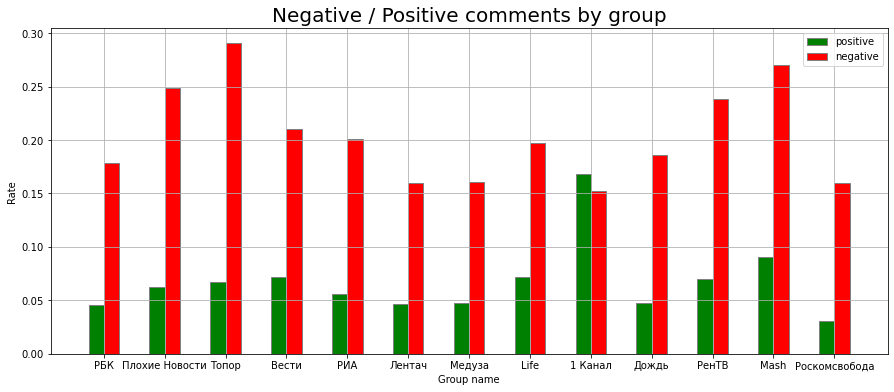

In [ ]:
# set width of bar
barWidth = 0.25
fig, ax = plt.subplots(figsize=(15,6))


# Set position of bar on X axis
br2 = np.arange(13)
br1 = [x - barWidth/2 for x in br2]
br3 = [x + barWidth/2 for x in br2]

# Make the plot
plt.bar(br1, comment_stats_pos.toPandas()['rate'],
        color ='green', width = barWidth,
        edgecolor ='grey', label ='positive')
#plt.bar(br2, comment_stats_neu.toPandas()['rate'],
#        color ='yellow', width = barWidth,
#        edgecolor ='grey', label ='neutral')
plt.bar(br3, comment_stats_neg.toPandas()['rate'],
        color ='red', width = barWidth,
        edgecolor ='grey', label ='negative')

plt.xticks(br2, total_comms_wname.toPandas()['group_name'])
plt.title('Negative / Positive comments by group', fontsize=20)
plt.xlabel('Group name')
plt.ylabel('Rate')
plt.grid()
plt.legend()

## Group with most spam comments

In [ ]:
# Group with greatest number of spam comments
comments.filter(col('from_id').isin(list(bots_trolls_banned.toPandas()['id'])))\
        .join(groups_df, groups_df.group_id == comments.owner_id, 'inner')\
        .groupBy('group_name')\
        .count()\
        .orderBy(col('count').desc())\
        .limit(1)\
        .toPandas()

,group_name,count
0,РБК,431876


## Top 10 posts with most spam comments

In [ ]:
most_spamful_posts = comments.filter(col('from_id').isin(list(bots_trolls_banned.toPandas()['id'])))\
                             .join(groups_df, groups_df.group_id == comments.owner_id, 'inner')\
                             .groupBy('owner_id', 'post_id')\
                             .count()\
                             .orderBy(col('count').desc())\
                             .limit(10)

In [ ]:
# For reading if needed data was already obtained
most_spamful_posts = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/most_spamful_posts')

In [ ]:
save_parquet(most_spamful_posts, 'most_spamful_posts')

In [ ]:
most_spamful_posts.join(groups_df, groups_df.group_id == most_spamful_posts.owner_id, 'inner')\
                  .select('owner_id','post_id','count','group_name')\
                  .orderBy(col('count').desc())\
                  .toPandas()

,owner_id,post_id,count,group_name
0,-150709625,8236914,377,Плохие Новости
1,-25380626,79652,371,1 Канал
2,-15755094,33153186,370,РИА
3,-150709625,9340121,346,Плохие Новости
4,-17568841,6400781,333,Дождь
5,-15755094,33791286,327,РИА
6,-24136539,5898815,317,Вести
7,-25232578,7598678,304,РБК
8,-15755094,32742675,296,РИА
9,-25380626,526951,287,1 Канал


Here are some of the posts that caused the most heated discussion involving accounts that were subsequently banned, or selected as trolls/bots:

**№1: "Плохие Новости", topic: Scandalous behavior in social media**

https://vk.com/public150709625?w=wall-150709625_8236914



---



**№2: "1 Канал", topic: Religious insults**

This post is somewhat of an outlier, as it dates back to 2012 and a bigger amount of accs are deleted

https://vk.com/public25380626?w=wall-25380626_79652

---

**№3: "РИА", topic: Event involving injury and reward of a police officer**

https://vk.com/public15755094?w=wall-15755094_33153186

---

**№4: "Плохие Новости", topic: Questional race-based statements**

https://vk.com/public150709625?w=wall-150709625_9340121

---

**№5: "Дождь\*", topic: Alexei Navalny's return to Russia**

*banned in Russia, only accessible with VPN

https://vk.com/public17568841?w=wall-17568841_6400781


## Groups with spam comment rates

In [ ]:
spam_shares = comments.filter(col('from_id').isin(list(bots_trolls_banned.toPandas()['id'])))\
                      .groupBy('owner_id')\
                      .count()

In [ ]:
spam_shares = spark.read.parquet('/tmp/juumnov-338467/Course_project_results/spam_shares')

In [ ]:
spam_shares = spam_shares.join(groups_df, groups_df.group_id == spam_shares.owner_id,'inner')\
                         .select('owner_id','group_name','count')

In [ ]:
spam_shares.toPandas()

,owner_id,group_name,count
0,-25380626,1 Канал,65032
1,-29534144,Лентач,84981
2,-25232578,РБК,431876
3,-45023092,Роскомсвобода,2291
4,-17568841,Дождь,185310
5,-24136539,Вести,135628
6,-170528132,Топор,79093
7,-76982440,Медуза,192614
8,-26493942,РенТВ,65663
9,-150709625,Плохие Новости,145665


In [ ]:
spam_group_data = spam_shares.join(total_comms, total_comms.group_id == spam_shares.owner_id)\
                             .select('group_id','group_name','count','comment_count')\
                             .withColumnRenamed("count","spam_comment_count")\
                             .orderBy(col('count').desc())\
                             .withColumn("spam_rate", col('spam_comment_count') / col('comment_count'))

spam_group_data.toPandas()

,group_id,group_name,spam_comment_count,comment_count,spam_rate
0,-25232578,РБК,431876,3171648,0.136168
1,-76982440,Медуза,192614,2151972,0.089506
2,-17568841,Дождь,185310,1532879,0.120890
3,-15755094,РИА,173620,2571905,0.067506
4,-150709625,Плохие Новости,145665,2921441,0.049861
5,-24136539,Вести,135628,2729678,0.049686
6,-24199209,Life,122561,2058120,0.059550
7,-29534144,Лентач,84981,2518342,0.033745
8,-170528132,Топор,79093,2826032,0.027987
9,-26493942,РенТВ,65663,1162335,0.056492


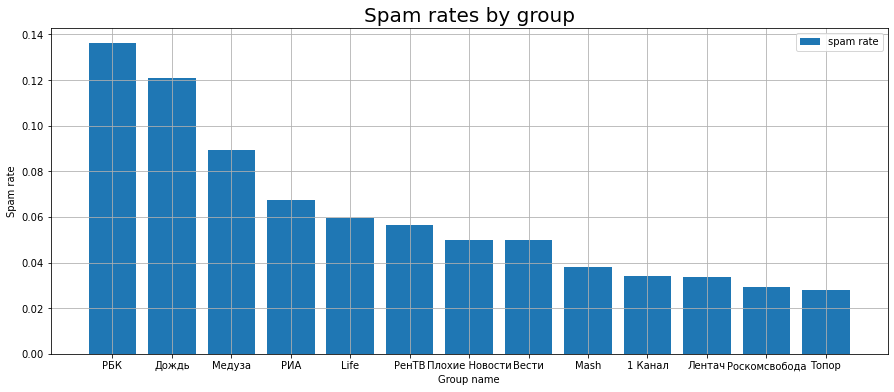

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
ax.bar(list(spam_group_data.orderBy(desc('spam_rate')).toPandas()['group_name']),
       list(spam_group_data.orderBy(desc('spam_rate')).toPandas()['spam_rate']), 
       label='spam rate')

plt.title('Spam rates by group', fontsize=20)
plt.xlabel('Group name')
plt.ylabel('Spam rate')
plt.grid()
plt.legend()

## "Positive, Neutral and Negative spam" insights